# MATH50003 (2024–25)
# Lab 5: III.2 LU Factorisation and III.3 Cholesky Factorisation

In this lab we explore using LU, PLU and Cholesky factorisations, and
implement algorithms for computing a Cholesky factorisation. We explore
stability properties of these different factorisations, and see that the
Cholesky factorisation is a robust way of determining if a matrix is symmetric
postive definite.

**Learning Outcomes**

Mathematical knowledge:

1. LU and PLU factorisations
2. Cholesky and reverse Cholesky factorisations, including for banded matrices.

Coding knowledge:

1. Using the `lu` and `cholesky` functions.

We load the following packages:

In [12]:
using LinearAlgebra, Plots, Test

### III.2 LU and PLU Factorisations

LU, PLU and Cholesky factorisations are closely related
matrix factorisations that reduce a square matrix to a product of
lower and upper triangular matrices, possibly with a permutation matrix.
We will only focus on the practical usage of LU and PLU, without digging into the
details of implementation.

### III.2.1 LU Factorisation

If $A ∈ 𝔽^{n × n}$ is a square matrix where $𝔽$ is a field ($ℝ$ or $ℂ$)
then we can sometimes find lower and upper triangular matrices $L,U ∈ 𝔽^{n × n}$ such that
$$
A = LU.
$$
This is equivalent to Gaussian elimination but we will only focus on practical usage in this lab.
This factorisation can be computed using the `lu` function, but as the default is a PLU factorisation we add a flag
telling it not to use pivoting/permutations:

In [13]:
A = [1.0 1 1;
     2   4 8;
     1   4 9]

L,U = lu(A, NoPivot()) # NoPivot is a flag that tells lu to not use permutations

LU{Float64, Matrix{Float64}, Vector{Int64}}
L factor:
3×3 Matrix{Float64}:
 1.0  0.0  0.0
 2.0  1.0  0.0
 1.0  1.5  1.0
U factor:
3×3 Matrix{Float64}:
 1.0  1.0   1.0
 0.0  2.0   6.0
 0.0  0.0  -1.0

This matches what we derived by hand in the notes and indeed:

In [14]:
@test A ≈ L*U

Test Passed

We can use an LU factorisation to reduce solving a linear system to inverting triangular matrices:

In [15]:
b = randn(3)
c = L \ b # computed using forward elimination (even though L is a Matrix, \ detects it is lower triangular)
x = U \ c # computed using back substitution
@test A \ b ≈ x

Test Passed

If a matrix has a zero on a pivot we know by equivalence to Gaussian elimination that an LU factorisation
does not exist:

In [5]:
A[1,1] = 0
lu(A, NoPivot()) # throws an error

LoadError: ZeroPivotException: factorization encountered one or more zero pivots. Consider switching to a pivoted LU factorization.

But even if it has a very small but non-zero entry we get huge errors:

In [16]:
A[1,1] = 1E-14
L,U = lu(A, NoPivot()) # Succeeds but suddenly U is on order of 2E14!

LU{Float64, Matrix{Float64}, Vector{Int64}}
L factor:
3×3 Matrix{Float64}:
 1.0     0.0  0.0
 2.0e14  1.0  0.0
 1.0e14  0.5  1.0
U factor:
3×3 Matrix{Float64}:
 1.0e-14   1.0      1.0
 0.0      -2.0e14  -2.0e14
 0.0       0.0      3.0

In [17]:
norm(A \ b - U\(L\b)) # Very large error! A \ b uses pivoting now.

0.00964770235425084

**WARNING** The parantheses are important: algebra is left-associative so had we written `U\L\b` this would have been interpreted as
`(U\L) \ b` which would have meant `inv(inv(U)*L)*b == L \ (U*b)`.

-----

**Problem 1** For `A` defined above, consider setting  `A[1,1] = ε` for `ε = 10.0 ^ (-k)` for `k = 0,…,14`
with the right-hand side `b = [1,2,3]`.
Plot, scaling the $y$-axis logarithmically, the growth rate in the error of using LU compared to `\`.
Make a conjecture on how the error grows as $k → ∞$.
Hint: you can either allocate a vector of errors that is populated in a for-loop or write a simple comprehension.

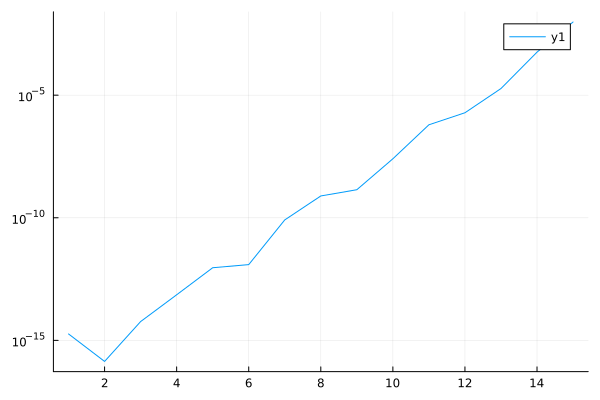

In [55]:
# TODO: Do a log-log plot for A with its 1,1 entry set to different ε and guess the growth rate.
n = 15
errors = [0.0 for _ = 1:n]
for k = 1:n
    eps = 10.0 ^ (-k + 1)
    A[1, 1] = eps
    L,U = lu(A, NoPivot())
    errors[k] = norm(A \ b - U\(L\b))
end

plot(1:n, errors; yscale=:log10)
# conjecture: grows exponentially

-----

## III.2.2 PLU Factorisation

In general it is necessary to use pivoting, a feature you have seen
in Gaussian elimination but as Problem 1 demonstrates we need to do so even if we do not encounter
a zero. This corresponds to a factorisation of the form
$$
 A = P^⊤LU
$$
where $P$ is a permutation matrix, $L$ is lower triangular and $U$ is upper triangular.
We compute this as follows, printing out the permutation:

In [56]:
A = [0.1 1 1;
     2   4 8;
     1   4 9]

L,U,σ = lu(A)
σ

3-element Vector{Int64}:
 2
 3
 1

The permutation matrix is encoded as a vector $σ$. More precisely, we have
$$
    P 𝐯 = 𝐯[σ]
$$
Thus we can solve a linear system by  first permuting the entries of the right-hand side:

In [57]:
b = [10,11,12]
b̃ = b[σ] # permute the entries to [b[2],b[3],b[1]]

3-element Vector{Int64}:
 11
 12
 10

And then inverting $L$ and $U$ as before:

In [58]:
c = L \ b̃ # invert L with forward substitution
x = U \ c # invert U with back substitution

@test x == A \ b # \ also use PLU to do the solve so these exactly equal

Test Passed

Note in the following problems we will see that PLU is _usually_ stable but not always.
Fortunately the set of matrices where it fails to be accurate has extremely small measure.
The big _open problem_ in numerical linear algebra is to turn this observation into a precise statement.

-----

**Problem 2(a)** Complete the function  `badmatrix(n)` that returns the following $ℤ^{n × n}$ matrix:
$$
  B_n := \begin{bmatrix}
      1      &&&& 1  \\
      -1 & 1       &&& 1   \\
      ⋮ & ⋱ & ⋱   && ⋮    \\
      -1 & ⋯ & -1 & 1 & 1 \\
      -1 & ⋯ & -1 & -1 & 1
  \end{bmatrix}
$$
That is: all entries below the diagonal are $-1$ whilst the diagonal and last column are $1$.

In [62]:
function badmatrix(n)
    # TODO: make the "bad matrix" with `Int` entries defined above and return it
    A = zeros(Int, n, n)
    for j = 1 : n - 1
        for i = j + 1 : n
            A[i, j] = - 1
        end
    end
    for i = 1:n
        A[i, i] = 1
    end
    A[:, end] = ones(Int, n)
    A
end

@test badmatrix(3) isa Matrix{Int}
@test badmatrix(3) == [1 0 1; -1 1 1; -1 -1 1]

Test Passed

**Problem 2(b)** Does `lu` use pivoting with `badmatrix(n)`? Does it use
pivoting with a small random perturbation (created via `randn(n,n)`)?

In [66]:
# TODO: Use `lu` on `badmatrix(n)` and a small perturbation to determine if it
# is using pivoting.
n = 5
bad = badmatrix(n)
b = randn(n)
L, U = lu(bad)
usesPivoting = !(bad \ b ≈ (U \ (L \ b)))
println(usesPivoting)

perturbed = bad + randn(n, n)
L, U = lu(perturbed)
usesPivoting = !(perturbed \ b ≈ (U \ (L \ b)))
println(usesPivoting)

false
true


**Problem 2(c)** We can test the accuracy of a method for inverting a matrix
by applying the matrix and seeing how different it was from the input, eg.
computing `norm(A*(A\b) - b)`. This would be zero if everything was done with
exact arithmetic. Plot the norm of this error for `b = randn(n)` for `bandmatrix(n)`
and `badmatrix(n) + 1E-15*randn(n,n)` for `n = 25, 50, 75, 100` and
compare the observed differences in accuracy of PLU.

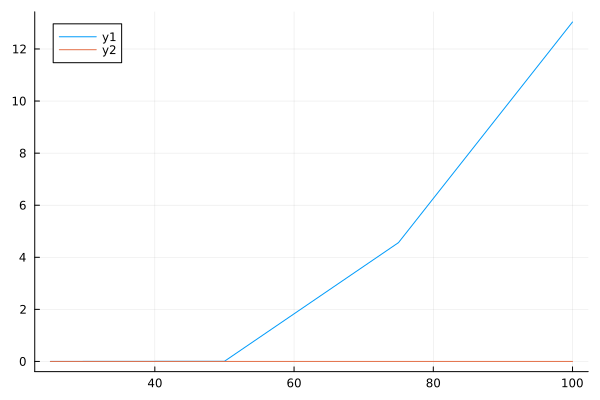

In [69]:
# TODO: plot the error norm(A*(A\b) - b) for the perturbed and unperturbed badmatrix(n).
# What do you observe?
ns = [25, 50, 75, 100]
errors1 = zeros(length(ns))
errors2 = zeros(length(ns))
for i in 1:length(ns)
    n = ns[i]
    A = badmatrix(n)
    b = randn(n)
    errors1[i] = norm(A * (A \ b) - b)

    A += 10.0 ^ (-15) * randn(n, n)
    errors2[i] = norm(A * (A \ b) - b)
end

plot(ns, errors1)
plot!(ns, errors2)

-----

## III.3 Cholesky factorisation

The Cholesky factorisation is a special case of LU factorisation for the case
when a matrix is symmetric positive definite (SPD). Hidden in the proof that a Cholesky factorisation
exists if and only if the matrix is SPD is a simple algorithm for computing it:

In [70]:
function mycholesky(A)
    T = eltype(A)
    m,n = size(A)
    if n ≠ m
        error("Matrix must be square")
    end
    if A ≠ A'
        error("Matrix must be symmetric")
    end

    L = LowerTriangular(zeros(T,n,n)) # a lower triangular matrix that at the end will satisfy L'L
    Aⱼ = copy(A)
    for j = 1:n
        α,𝐯 = Aⱼ[1,1],Aⱼ[2:end,1]
        if α ≤ 0
            error("Matrix is not SPD") # this error would be a proof that the matrix is not SPD, if done rigorously
        end
        L[j,j] = sqrt(α)
        L[j+1:end,j] = 𝐯/sqrt(α)

        # induction part
        K = Aⱼ[2:end,2:end] # drop first row and column of A
        Aⱼ = K - 𝐯*𝐯'/α
    end
    L
end

A = Symmetric(rand(100,100) + 100I) # Symmetric takes in a matrix and produces a symmetric version using the upper-triangular part.
L = mycholesky(A)
@test A ≈ L*L'

Test Passed

With exact arithmetic algorithm succeeds if and only if $A$ is symmetric positive definite.
With floating point errors this is not necessarily the case. (One could run it with interval arithmetic
but that would only prove a matrix is SPD if the algorithm succeeded, failure could be caused by
rounding.)

In practice one would normally use the inbuilt `cholesky` function as follows:

In [71]:
L̃ = cholesky(A).L
@test L̃ ≈ L # our implementation matches (approximately) the high-performance implementation.

Test Passed

In the following problem we consider a Cholesky factorisation for tridiagonal matrices. Since we are assuming the
matrix is symmetric, we will use a special type `SymTridiagonal` that captures the symmetry.
In particular, `SymTridiagonal(dv, ev) == Tridiagonal(ev, dv, ev)`.

-----

**Problem 3** Use `mycholesky` or `cholesky` to deduce if the following matrices are SPD.
$$
\begin{bmatrix} 1 & -1  \\
-1 & 3
\end{bmatrix}, \begin{bmatrix} 1 & 2 & 2  \\
2 & 1 & 2\\
2 & 2 & 1
\end{bmatrix}, \begin{bmatrix} 3 & 2 & 1  \\
2 & 4 & 2\\
1 & 2 & 5
\end{bmatrix},
\begin{bmatrix} 4 & 2 & 2 & 1  \\
2 & 4 & 2 & 2\\
2 & 2 & 4 & 2 \\
1 & 2 & 2 & 4
\end{bmatrix}
$$

In [79]:
# TODO: Check if you got PS5 Q1 correct using a computer to do the Cholesky factorisation.
A = [1 -1;
     -1 3]
cholesky(A).L

2×2 LowerTriangular{Float64, Matrix{Float64}}:
  1.0   ⋅ 
 -1.0  1.41421

**Problem 4** Complete the following
implementation of `mycholesky` to return a `Bidiagonal` cholesky factor in $O(n)$ operations.

In [98]:
# return a Bidiagonal L such that L'L == A (up to machine precision)
# You are allowed to change A
function mycholesky(A::SymTridiagonal)
    # 1 8 0 0 0
    # 8 2 9 0 0
    # 0 9 3 8 0
    # 0 0 8 4 9
    # 0 0 0 9 5
    
    d = A.dv # diagonal entries of A
    u = A.ev # sub/super-diagonal entries of A
    T = float(eltype(A)) # return type, make float in case A has Ints
    n = length(d)
    ld = zeros(T, n) # diagonal entries of L
    ll = zeros(T, n-1) # sub-diagonal entries of L

    # TODO: populate the diagonal entries ld and the sub-diagonal entries ll
    # of L so that L*L' ≈ A
    α = d[1]
    for i = 1:n-1
        ld[i] = √α
        ll[i] = u[i] / √α
        α = d[i + 1] - (u[i] ^ 2) / α
    end
    ld[n] = √α

    Bidiagonal(ld, ll, :L)
end

n = 1000
A = SymTridiagonal(2*ones(n),-ones(n-1))
L = mycholesky(A)
@test L isa Bidiagonal
@test L*L' ≈ A

Test Passed

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*